In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.sparse
import scipy.linalg

# Poisson Equation (with conductivity term)

Now consider the following modification of Diriclet problem for the poisson equation in two dimension, $\textbf{x} = (x,y) \in \Omega \subset R^2$, where we add a conductivity term $q(\textbf{x})>0$

$$
\begin{cases}
    - q(\textbf{x})\Delta y(\textbf{x}) = f(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \Omega \\
    y(\textbf{x}) = g(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \partial \Omega
\end{cases}
$$
i.e
$$
\begin{cases}
    - \Delta y(\textbf{x}) = \frac{f(\textbf{x})}{q(\textbf{x})} \;\;\;\;\;\;\;\;\;  \textbf{x} \in \Omega \\
    y(\textbf{x}) = g(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \partial \Omega
\end{cases}
$$
This formulation is equivalent to a rescaling of the source terms to take into account the conductivity.

## Finite difference solver, matrix form
The previous linear system can be rewritten as follows
$$
A\textbf{u}_h = - h^2 \textbf{qf} - \textbf{b}
$$

where 
- $A \in R^{N \times N}$ tridiagonal block matrix made of the following block

$$
    A = 
 \begin{pmatrix}
T & I &  &  &  & &  \\
I & T & I &  &  &  &  \\
 &  &  &\ddots & & & \\
 &  &  &  I & T & I  \\
 &  &  &  & I & T & I \\
 &  &  &  &  & I & T 
\end{pmatrix}
$$
 
here $I \in R^{N_x \times N_x}$ is an identity matrix and $T \in R^{N_x \times N_x}$ is a tridiagonal matrix

$$
    T = 
 \begin{pmatrix}
-4 & 1 &  &  &  & &  \\
1 & -4 & 1 &  &  &  &  \\
 &  &  &\ddots & & & \\
 &  &  &  1 & -4 & 1  \\
 &  &  &  & 1 & -4 & 1 \\
 &  &  &  &  & 1 & -4 
\end{pmatrix}
$$


A is symmetric, positive definite and so non singular. Thus we can cocnlude that the finite difference system admits admits an unique solution $\textbf{u}_h$. 
It is worth pointing out that $A$ is ill-conditioned: it is condition number grows like $h^{-2}$ as $h$ tends to zero.

- $\textbf{u}_h \in R^N $ is our unknown solution

$$ 
    \textbf{u}_h = 
    \begin{pmatrix}
        \textbf{u}_{1} \\
        \textbf{u}_{2} \\
        \vdots \\
        \textbf{u}_{j} \\
        \vdots \\
        \textbf{u}_{Nx} \\
    \end{pmatrix}
    \;\; \;\;\;\;\;\;\;
    \textbf{u}_j = 
    \begin{pmatrix}
        u_{1,j} \\
        u_{2,j} \\
        \vdots \\
        u_{Ny,j} \\
    \end{pmatrix}
    \;\;\;\; j = 1,\dots,N_x
$$

here each $\textbf{u}_j$ represent a column of the matrix composed by the internal nodes

<!---
$$
    \textbf{u}_h = 
    \begin{pmatrix}
        u_{1,1} \\
        u_{2,1} \\
        \vdots \\
        u_{Ny,1} \\
        u_{1,2} \\
        \vdots \\
        u_{Ny,2} \\
        \vdots \\
        u_{1,Nx} \\
        \vdots \\
        u_{Ny,Nx} \\
    \end{pmatrix}
$$
-->

- $\textbf{qf} \in R^N $ is now our __source with conductivty interaction vector (NEW)__

$$
                \textbf{qf} = 
                \begin{pmatrix}
        \textbf{qf}_{1} \\
        \textbf{qf}_{2} \\
        \vdots \\
        \textbf{qf}_{j} \\
        \vdots \\
        \textbf{qf}_{Nx} \\
        \end{pmatrix}
        \;\; \;\;\;\;\;\;\;
        \textbf{qf}_j = 
        \begin{pmatrix}
        q_{1,j}f_{1,j} \\
        q_{2,j}f_{2,j} \\
        \vdots \\
        q_{Ny,j}f_{Ny,j} \\
        \end{pmatrix}
    \;\;\;\; j = 1,\dots,N_x
$$

- $\textbf{b} = \textbf{b}_{left/right } + \textbf{b}_{top/bottom}\in R^N $ is the vector of boundary conditions, where

$$
        \textbf{b} = 
    \begin{pmatrix}
        \textbf{b}_{1} \\
        \textbf{b}_{2} \\
        \vdots \\
        \textbf{b}_{j} \\
        \vdots \\
        \textbf{b}_{Nx} \\
    \end{pmatrix}
    \;\; \;\;\;\;\;\;\;
    \textbf{b}_j =  \textbf{b}_{left/right,j } + \textbf{b}_{top/bottom,j}
    \;\;\;\; j = 1,\dots,N_x
$$

and

$$
    \textbf{b}_j = \textbf{b}_{left/right,j } + \textbf{b}_{top/bottom,j} = 
    \begin{cases}
\;\;\;
  \begin{pmatrix}
        \textbf{g}_{0,j} \\
        \vdots \\
        0 \\
        \vdots \\
        \textbf{g}_{N_{y+1},j} \\
    \end{pmatrix} 
 \;\;\; + \;\;\;
       \begin{pmatrix}
        0 \\
        \vdots \\
        0 \\
        \vdots \\
        0 \\
    \end{pmatrix} 
    \;\;\;\;\;\;\;\;\; j=2,\dots,N_{x-1}  \\
\\
\;\;\;
      \begin{pmatrix}
        \textbf{g}_{0,1} \\
        \vdots \\
        0 \\
        \vdots \\
        \textbf{g}_{N_{y+1},1} \\
    \end{pmatrix} 
 \;\;\; +\;\;\;
       \begin{pmatrix}
        \textbf{g}_{1,0} \\
        \vdots \\
        \textbf{g}_{i,0} \\
        \vdots \\
        \textbf{g}_{N_y,0}\\
    \end{pmatrix} 
    \;\;\;\;\;\;\;\;\; j=1  \\
\\
\;\;\;
       \begin{pmatrix}
        \textbf{g}_{0,N_x} \\
        \vdots \\
        0 \\
        \vdots \\
        \textbf{g}_{N_{y+1},N_x} \\
    \end{pmatrix} 
 \;\;\; + \;\;\;
       \begin{pmatrix}
        \textbf{g}_{1,N_{x+1}} \\
        \vdots \\
        \textbf{g}_{i,N_{x+1}} \\
        \vdots \\
        \textbf{g}_{N_y,N_{x+1}}\\
    \end{pmatrix} 
    \;\;\;\;\;\;\;\;\; j=N_x  \\
    \end{cases}
$$

So with respect to the previous implementation, only the vector $\textbf{f}$ need to be modified
$$
\textbf{f} \rightarrow \textbf{qf}
$$

## Example

Consider the following problem setting 
$$ 
\Omega = (0,1)^2,
$$

$$
f(x,y) = 8\pi sin(2\pi x)*cos(2\pi y)
$$

$$
    g(0,y) = g(1,y) = 0 
$$

$$
g(x,0) =g(x,1) = sin(2\pi x) \;\;\; 0<x<1  
$$

$$
q(x,y) = sin(2\pi x,2\pi y)
$$

In [4]:
# Parameters
n_x = n_y = 20
n = n_x*n_y
a = 0
b = 1
c = 0
d = 1

# Conductivity term NEW
def q(x,y):
    return np.sin(2*np.pi*x)*np.cos(2*np.pi*y)
    #return x**2 + y**2 +1
    #return np.zeros((1,1))

# Source term
def f(x,y):
    return 8*np.pi**2*np.sin(2*np.pi*x)*np.cos(2*np.pi*y)

# Boundary terms
def g_top_bottom(x):
    return np.sin(2*np.pi*x)

def g_left_right():
    return 0

# Exact solution
def u_ex(x,y):
    return np.sin(2*np.pi*x)*np.cos(2*np.pi*y)


## Define the Grid

In [5]:
# Define the grid s.t. x_0 = a, x_n+1 = b, y_0 = c, y_n+1 = d
x = np.linspace(a, b, n_x+1+1)
y = np.linspace(c, d, n_y+1+1)
xv, yv = np.meshgrid(x, y)

# Set h -IMPORTANT
h = x[1]-x[0]

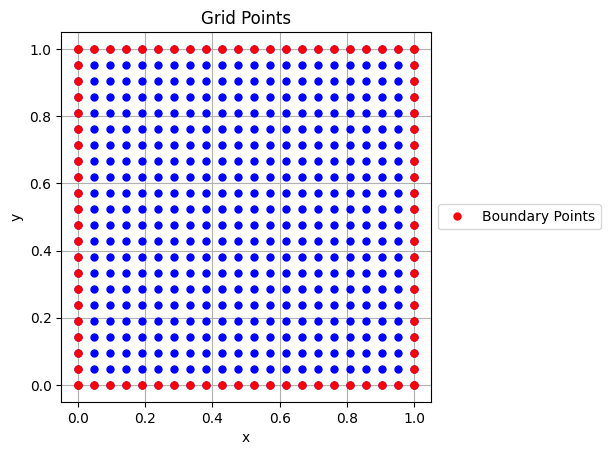

In [6]:
# Plot the grid
plt.plot(xv, yv, marker='o', linestyle='none', color='blue', markersize=5)

# Plot the boundary points
plt.plot(xv[:, 0], yv[:, 0], marker='o', linestyle='none', color='red', markersize=5, label='Boundary Points')  # Left boundary
plt.plot(xv[:, -1], yv[:, -1], marker='o', linestyle='none', color='red', markersize=5)  # Right boundary
plt.plot(xv[0, :], yv[0, :], marker='o', linestyle='none', color='red', markersize=5)  # Top boundary
plt.plot(xv[-1, :], yv[-1, :], marker='o', linestyle='none', color='red', markersize=5)  # Bottom boundary

plt.xlabel('x')
plt.ylabel('y')
plt.title('Grid Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

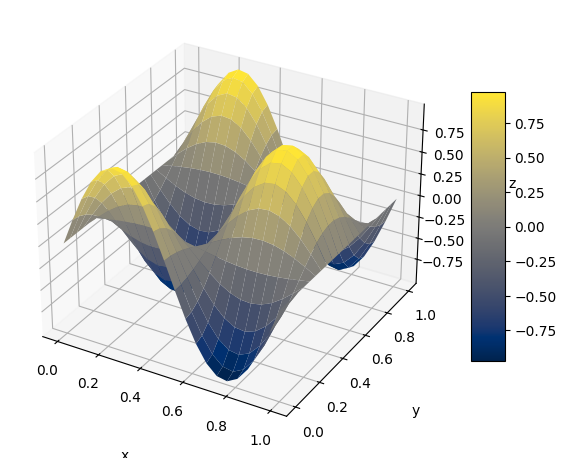

In [7]:
# Plot the conductivity term q
z = q(xv, yv)
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

## Define the boundary condition

In [8]:
# Set the boundary value of above defined approximated solution to the known boundary value
u_h = np.zeros((n_x+1+1,n_y+1+1))

# Left and Right boundary
for i in np.arange(n_x+1):
    u_h[i, 0] = g_left_right() # Left
    u_h[i, n_x+1] = g_left_right() # Right

# Top and bottom boundary
for j in np.arange(n_x+1):
    u_h[0, j] = g_top_bottom(x[j]) # Bottom
    u_h[n_y+1, j] = g_top_bottom(x[j]) # Top


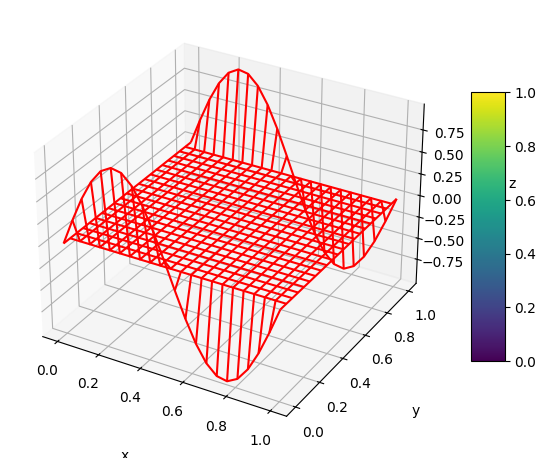

In [9]:
# Plot the boundary value
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_wireframe(xv, yv, u_h,color='r')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

## Implement the finite difference solver

In [10]:
# Compute A
def compute_A(n_x, n_y):

    D = np.eye(n_x)
    k = [np.ones(n_x-1),-4*np.ones(n_x), np.ones(n_x-1)]
    T = scipy.sparse.diags(k, [-1,0,1]).toarray()

    I1 = np.eye(n_y)
    I2 = np.eye(n_y, k=1)
    I3 = np.eye(n_y, k=-1)

    A1 = np.kron(I1, T)
    A2 = np.kron(I2, D)
    A3 = np.kron(I3, D)
    A = A1 + A2 + A3

    return A

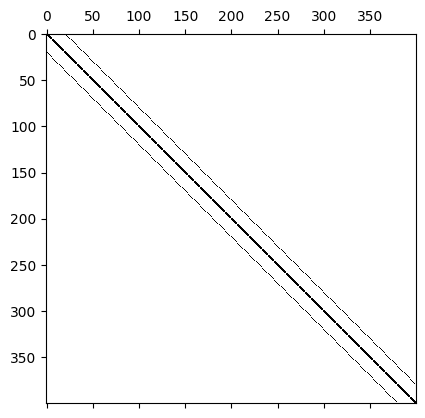

In [63]:
A = compute_A(n_x,n_y)
plt.spy(A)

In [11]:
# Compute the source with conductivity interaction vector qf
def compute_qf(n,n_x,n_y):
    fqv = np.zeros(n)

    for i in np.arange(n_x):
        for j in np.arange(n_y):
            fqv[i + n_y*j] = (1/q(x[i+1], y[j+1]))*f(x[i+1], y[j+1])

    return fqv 

# Compute the boundary vector b = b_top/bottom + b_left/right 
def compute_b(n, n_x, n_y):
    
    b_top_bottom=np.zeros(n)
    for i in range (0,n_x):
        b_top_bottom[i]=g_top_bottom(x[i+1]) # Bottom Boundary
        b_top_bottom[i+(n_x)*(n_y-1)]=g_top_bottom(x[i+1]) # Top Boundary
      
    b_left_right=np.zeros(n)
    for j in range (0,n_y):
        b_left_right[(n_y)*j]=g_left_right() # Left Boundary
        b_left_right[n_y-1+(n_y)*j]=g_left_right() # Right Boundary

    return b_left_right+b_top_bottom

In [12]:
def discrete_poisson_problem_solver(a,b,c,d,h, n, n_x, n_y):
    A = compute_A(n_x, n_y,)
    bv = compute_b(n, n_x, n_y)
    fqv = compute_qf(n, n_x, n_y)

    u_h = np.linalg.solve(A, -(h**2)*fqv-bv)

    return u_h

## Solve the system

In [13]:
# Solve the system
sol = discrete_poisson_problem_solver(a,b,c,d,h,n,n_x,n_y)

# Reshape the solution to 2d matrix again
u_h[1:n_x+1, 1:n_y+1] = sol.reshape((n_x,n_y))

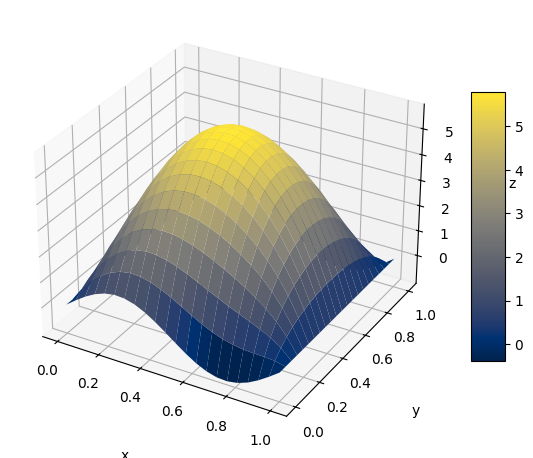

In [14]:
# Visualize the result
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, u_h, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

# Rereferences:
- Scientific Computing with MATLAB and Octave, A.Quarteroni, F.Saleri
- Numerical Methods for Differential Equations with Python, J.S. Butler https://johnsbutler.netlify.app/files/Teaching/Numerical_Analysis_for_Differential_Equations.pdf
- https://john-s-butler-dit.github.io/NumericalAnalysisBook/Chapter%2009%20-%20Elliptic%20Equations/903_Poisson%20Equation-Boundary.html
- Numerical Solution of the Poisson Equation Using Finite Difference Matrix Operators, Mohammad Asif Zaman